In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
import timm
print(timm.__version__)
from fastcore.parallel import *
from PIL import Image
from fastai.vision.all import *
from sklearn.metrics import classification_report

1.0.7


In [ ]:
# import zipfile

# zip_file_path = '/content/drive/MyDrive/archive.zip'
# extract_dir = '/content/drive/MyDrive/unzipped'  # specify the directory to extract to

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f"Unzipped contents to {extract_dir}")

In [ ]:
trn_path = '/content/drive/MyDrive/pest/train'
test_dir = '/content/drive/MyDrive/pest/test'

In [ ]:

path = "/content/drive/MyDrive/pest"

# Define function to get image sizes
def f(o): return PILImage.create(o).size

# Load files and get image sizes in parallel
files = get_image_files(path)
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(275, 183)      373
(259, 194)      224
(225, 225)      199
(300, 168)      184
(318, 159)       53
               ... 
(2400, 1800)      1
(2000, 1125)      1
(600, 442)        1
(650, 350)        1
(1100, 734)       1
Name: count, Length: 264, dtype: int64

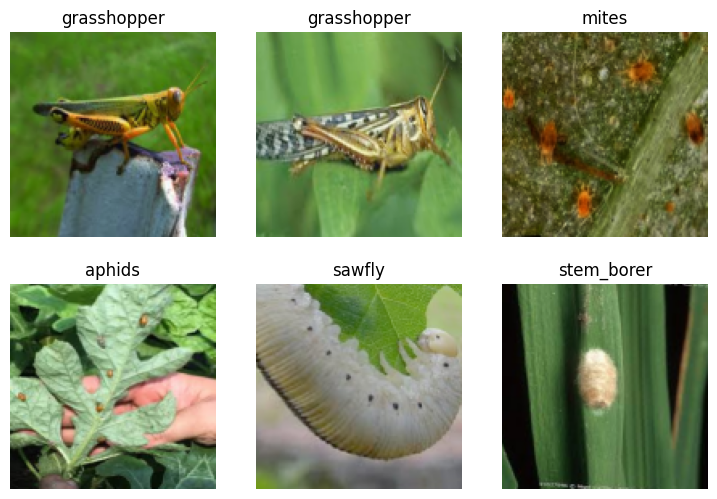

In [ ]:
# Load data
trn_path = path+'/train'
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,error_rate,time
0,2.081582,1.262982,0.325926,00:34


epoch,train_loss,valid_loss,error_rate,time
0,1.105196,0.712000,0.227778,00:35
1,0.882809,0.563382,0.214815,00:33
2,0.774137,0.473610,0.155556,00:34
3,0.653259,0.393021,0.125926,00:34
4,0.569087,0.306313,0.100000,00:34
5,0.489946,0.235312,0.068519,00:34
6,0.444865,0.212938,0.072222,00:35
7,0.409895,0.232081,0.062963,00:34
8,0.380044,0.183535,0.048148,00:33
9,0.354747,0.183657,0.061111,00:33


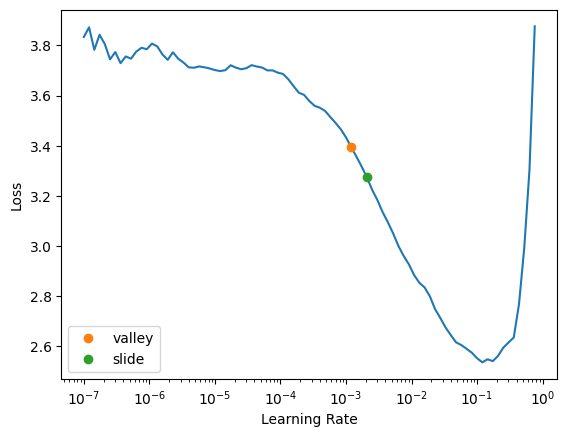

In [ ]:
# Define model
learn = vision_learner(dls, 'efficientnet_b4', metrics=error_rate, path='.').to_fp16()

# Find optimal learning rate
learn.lr_find(suggest_funcs=(valley, slide))

# Train model
learn.fine_tune(100,0.01)

In [ ]:
# Predict on test data
# path+'/train'
tst_files = get_image_files(path+'/test').sorted()
tst_dl = dls.test_dl(tst_files)
print(tst_files[0:3])
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
print(idxs)
print(dls.vocab)

[Path('/content/drive/MyDrive/pest/test/aphids/jpg_0 - Copy.jpg'), Path('/content/drive/MyDrive/pest/test/aphids/jpg_0.jpg'), Path('/content/drive/MyDrive/pest/test/aphids/jpg_11 - Copy.jpg')]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 1, 3, 8, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5,

In [ ]:
# Map indices to labels
mapping = dict(enumerate(dls.vocab))
reverse_mapping=dict(zip(dls.vocab,list(range(len(dls.vocab)))))
print(mapping)
print(reverse_mapping)

{0: 'aphids', 1: 'armyworm', 2: 'beetle', 3: 'bollworm', 4: 'grasshopper', 5: 'mites', 6: 'mosquito', 7: 'sawfly', 8: 'stem_borer'}
{'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}


In [ ]:
# Create results series
results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
display(results)

# Create testY
testY=[]
for item in tst_files:
    testY+=[reverse_mapping[item.parent.name]]

# Print classification report
print(classification_report(testY,idxs,target_names=dls.vocab,digits=4))

0          aphids
1          aphids
2          aphids
3          aphids
4          aphids
          ...    
445    stem_borer
446    stem_borer
447    stem_borer
448        aphids
449        aphids
Name: idxs, Length: 450, dtype: object

              precision    recall  f1-score   support

      aphids     0.9259    1.0000    0.9615        50
    armyworm     0.9434    1.0000    0.9709        50
      beetle     0.9259    1.0000    0.9615        50
    bollworm     0.9787    0.9200    0.9485        50
 grasshopper     1.0000    0.9800    0.9899        50
       mites     1.0000    0.9200    0.9583        50
    mosquito     1.0000    1.0000    1.0000        50
      sawfly     0.9574    0.9000    0.9278        50
  stem_borer     0.9400    0.9400    0.9400        50

    accuracy                         0.9622       450
   macro avg     0.9635    0.9622    0.9621       450
weighted avg     0.9635    0.9622    0.9621       450



In [ ]:
learn.export('pest_model.pkl')

In [ ]:
# from fastapi import FastAPI, File, UploadFile
# from fastai.vision.all import *
# from PIL import Image

# learn = load_learner('pest_model.pkl')

# # Create FastAPI app
# app = FastAPI()

# @app.post("/predict")
# async def predict(file: UploadFile = File(...)):
#     img = await file.read()
#     img = Image.open(io.BytesIO(img))

In [ ]:
# uvicorn main:app --host 0.0.0.0 --port 8000